# Sec 50: ... so can we use this distribution as a prior?

Yes!  We certainly can.  There's no reason priors have to be one dimensional.  The Bayesian approach is all about **generative** modeling. What this means, is that we think about how our data was generated.  This might be the most important concept to take home from this course.  

- **We assume our data was generated by a high dimensional multivariate normal**.  
- **Every point in the $x$ axis, is one dimension of the multivariate normal.**
- **Priors that describe **smoothness** are key to building good models.**  "smoothness" is the same as saying, "nearby points strongly influence other nearby points", which allows us to use the information in the data more efficiently.

So now let's generate some fake data and try it out.  Here's our example dataset.  It's binary data, or binary classification.  To make it a bit more interesting, we'll generate data with a increase, a dip, and another increase.  There are a lot of cases we could imagine working like this.  For instance, this may represent the amount of time spent on website and probability of checking out.  People who spend little time may have arrived with the intention to buy.  People who browse for a long time may have arrived with the intention to buy, but just didn't know which one.  People who poke around for a little while may be the least likely to make a purchase. 

This is somewhere where we might first think to apply a logistic regression, or since there's a non-linear effect we wish to capture, perhaps a random forest classifier.  But since this is Intuitive Bayes, we'll build a Bayesian model. 

There is one input here, `x`.  The probability of the positive class.  It starts is high, then goes low, then high again as x increases.

## Sec 51:  An example using count data

First we're going to introduce an example of inferring the underlying rate of some pretty generic count data.  This part might be a review for you.  If it is, feel free to skip ahead or put it on 2x speed.  Afterwards, we're going to extend this example to add some time dependence which will motivate our next step towards developing GPs.  Here's your scenario:

Say you're modeling the amount of orders placed in your online shop, and you want to try estimate the number of orders placed per day.  Here's a plot of your raw data.

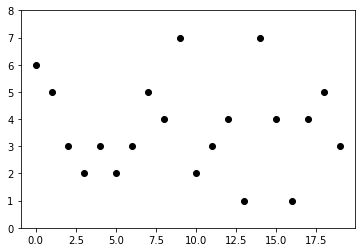

In [237]:
n_days = 20
true_avg_sales = 4
sales = np.random.poisson(lam=true_avg_sales, size=n_days)

plt.plot(np.arange(n_days), sales, "ok");
plt.ylim([0, max(sales) + 1]);

The first thing you should do is pull up your favorite SQL terminal and type something along the lines of `select avg(*) from sales group by day`, and then plot the counts, like we did above.  The next thing you can do is whip up a quick Bayesian model, which will help you understand the uncertainty in your estimate of the average.  Using PyMC, we can estimate the average number of sales per day using a Poisson likelihood, which is the default distribution for count data we have.  First we'll plot our prior (decide for yourself if you think it's reasonable -- feel free to experiment with other choices), then we'll write down the model.  It's amazing how much can be done in 5 lines of code.

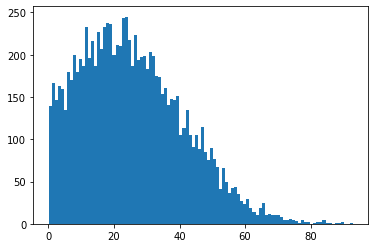

In [250]:
plt.hist(pm.draw(pm.TruncatedNormal.dist(mu=20, sigma=20, lower=0.0), 10000), 100);

In [251]:
with pm.Model() as model:
    avg_sales = pm.TruncatedNormal("avg_sales", mu=20, sigma=20, lower=0.0) # weakly informative prior constraints the avg_sales to be a positive number
    pm.Poisson("sales", mu=avg_sales, observed=sales)
    
    idata = pm.sample(tune=5000)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [avg_sales]
INFO:pymc:NUTS: [avg_sales]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 15 seconds.
INFO:pymc:Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.7127, but should be close to 0.8. Try to increase the number of tuning steps.


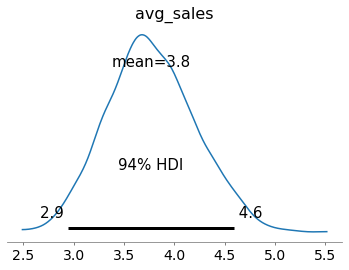

In [252]:
az.plot_posterior(idata, var_names=["avg_sales"]);

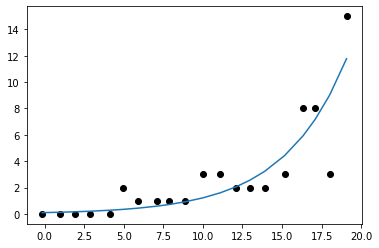

In [249]:
np.random.seed(50)

N = 20
x = np.arange(N) + 0.1*np.random.randn(N) # not exactly on round numbers

mu_true = 0.1 * np.exp(0.25 * x)
y = np.random.poisson(lam=mu_true)

plt.plot(x, y, "ok");
plt.plot(x, mu_true);

In [210]:
## model 1
N = len(x) # number of data points
with pm.Model() as model:
    
    # scale the variance of the prior
    eta = pm.HalfNormal("eta", sigma=1)
   
    # A multivariate normal random vector prior, with no correlation between elements
    mu = np.zeros(N)
    cov = eta**2 * np.diag(np.ones(N))
    f = pm.MvNormal("f", mu=mu, cov=cov)
    
    mu = pm.Deterministic("mu", pm.math.exp(f))
    lik = pm.Poisson("lik", mu=mu, observed=y)

with model:
    idata = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, f]
INFO:pymc:NUTS: [eta, f]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.


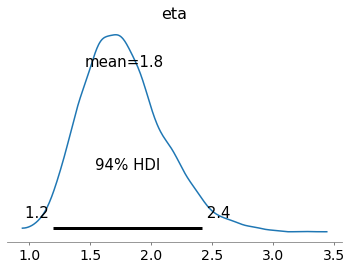

In [211]:
az.plot_posterior(idata, var_names=['eta']);

In [209]:
mu = idata.posterior.mu.stack(samples=['chain', 'draw']).values

plt.fill_between(x, np.percentile(mu, 5, axis=1), np.percentile(mu, 95, axis=1), edgecolor="k", color="slateblue", alpha=0.7)
plt.plot(x, np.mean(mu, axis=1), color="k");
plt.plot(x, y, "ok");

AttributeError: 'Dataset' object has no attribute 'mu'

We can see that's it's not really representing the data well.  `p` is kind of higher on the left and right, but not really.  There's also a lot of uncertainty.  Not to anthropomorphize, but our model doesn't know that data points that are near by in terms of $x$, should also be nearby in terms of $p$.  Nothing about the prior would indicate this.  It would take a lot more than 15 data points for the model to learn this relationship.  

So let's help it along.  Let's give the model a nudge in this direction by including this correlation in our prior.  We know that data points that are nearby in terms of $x$, should also be nearby in terms of $p$.  We don't know by how much though.  We can use kernels to parameterize these relationships though!  Remember the lengthscale parameter?  We don't know it, but we can put a prior on it.  

Putting priors on GP **hyperparameters** like `eta` and `lengthscale` is an important and topic on it's own.  For now we're just going to do something simple here, but we'll come back to this topic later.

In [156]:
## model 2
N = len(x) # number of data points
with pm.Model() as model:
    
    # scale the variance of the prior
    eta = pm.HalfNormal("eta", sigma=10)
    
    # The lengthscale is unknown, since we're Bayesians we put a prior on it
    lengthscale = pm.Uniform("lengthscale", lower=1, upper=20)

    # A multivariate normal random vector prior, with correlation between the inputs
    # We're using the pm.gp.cov.ExpQuad function in PyMC, which implements basically 
    # the same code that we wrote earlier in our function called "kernel".  You should
    # use it though, because extra care has gone into testing it and making it numerically
    # stable.  
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=lengthscale)
    K = cov_func(x[:, None])
    
    ## This is the non-centered parameterization of a multivariate normal
    # without it, you wouldn't be able to sample from a GP.  This is an implementation
    # trick you need to do to make this work properly.  There are actually two implementation
    # tricks here, the second being adding a very small diagonal to the kernel matrix K.  Software libraries
    # like PyMC take care of this for you, so you won't need to worry about it in the future.
    K = at.linalg.cholesky(K + 1e-6*at.identity_like(K))
    v = pm.Normal("v", mu=0.0, sigma=1.0, size=len(x))
    f = at.dot(K, v)

    p = pm.Deterministic("p", pm.math.sigmoid(f))
    lik = pm.Bernoulli("lik", p=p, observed=y)

with model:
    idata = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, lengthscale, v]
INFO:pymc:NUTS: [eta, lengthscale, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 106 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 106 seconds.


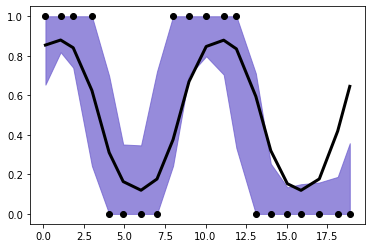

In [157]:
p = idata.posterior.p.stack(samples=['chain', 'draw']).values

plt.fill_between(x, np.percentile(p, 5, axis=1), np.percentile(p, 95, axis=1), edgecolor="k", color="slateblue", alpha=0.7)
plt.plot(x, p_true, color="k", lw=3);
plt.plot(x, y, "ok");

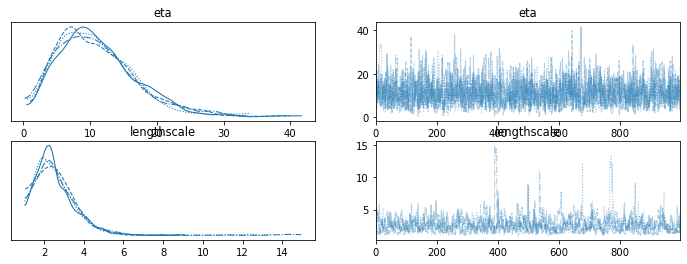

In [158]:
az.plot_trace(idata, var_names=["eta", "lengthscale"]);

## Things look much better!  But it's still a bit incomplete

To see, let's plot this a little differently.  We'll plot the same posterior samples but with dots instead of lines:

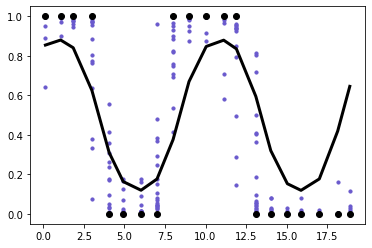

In [159]:
p = idata.posterior.p.stack(samples=['chain', 'draw']).values

ix = np.random.randint(0, p.shape[1], 20)
for i in range(len(ix)):
    plt.scatter(x, p[:, i], color="slateblue", s=10);
plt.plot(x, p_true, color="k", lw=3);
plt.plot(x, y, "ok");

We'll add a very faint line now, to show which points are coming from which sample, but know that the data is only at the locations of the blue dots.

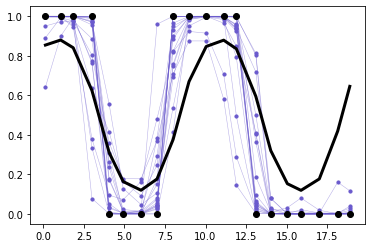

In [160]:
p = idata.posterior.p.stack(samples=['chain', 'draw']).values

ix = np.random.randint(0, p.shape[1], 20)
for i in range(len(ix)):
    plt.scatter(x, p[:, i], color="slateblue", s=10);
    plt.plot(x, p[:, i], color="slateblue", lw=0.5, alpha=0.5);
plt.plot(x, p_true, color="k", lw=3);
plt.plot(x, y, "ok");

Here's the problem.  **We only predicted at the x locations of the observed data points**.  You'll notice that the dimensionality of the GP `f` (and then the transformed version `p`) is exactly the same as the data.

In [161]:
idata.posterior.p.shape # 4 chains, 1000 draws, 20 data points, one for each x

(4, 1000, 20)

In [163]:
x.shape # 20 x locations

(20,)

We really have a random vector here, not a random function.  In the next section, we'll show how we can combine the two facts that the covariance function is an actual function, and the number of dimensions of multivariate normals is somewhat flexible, to finally unveil Gaussian processes.

## Section Recap
* We wanted to classify checkout probability as a function of time
* We can assume our data was generated by one giant MVN
  * With uniform covariance our MVN is not able estimate similarity between points
  * With just a nudge from a kernel generated covariance our fit gets much better
* This almost a full Gaussian process
  * We can only make **in sample** predictions at observed data points
  * We cannot yet predict in sample or forecast to future outcomes
* To get this to sample well we need to apply a couple computational tricks
  * Modern GP libraries implement these for you under the hood

# Sec 60: Random functions

To have a GP, we need to realize that the *kernel is a function*.  **We can plug any x-values, not just the x-values where our data is located**.  This is why a GP is said to be infinite dimensional, because it can be seen at any `x` location (and there are infinite points on the `x` axis!)

Remember that function is a mathematical object, or a box, where you can give it an input, or an $x$ value (from the domain the function is defined over), and out from the other side comes some output value.  Let's take this one step at a time.  Using the same data and code, let's add a 16th data point to `x`, but one where we don't have any observations for `y`. 

Since we still only have 15 observed data points, (x, y) pairs, we need to index `p` to not include the new `x` we just added when we pass it into the likelihood.  (Remember that the likelihood is a function of the observed data).  Other than that, you'll see that the model code is the same. 

(ANIMATION HERE): have Fadi highlight the lines of code as we talk though them.  Like, "first MCMC proposes a value of eta, and lengthscale (highlight that)...". Talk through the fact that the covariance matrix K is 16 by 16 now (instead of 15 by 15 before).. 

In [164]:
# append the new x's to the end
x_new = 4.46 
x_both = np.concatenate((x, [x_new]))

with pm.Model() as model:
    # Since we don't know them, we put distributions on the parameters of the kernel, like the lengthscale
    eta = pm.HalfNormal("eta", sigma=1)
    lengthscale = pm.Uniform("lengthscale", lower=1, upper=5)
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=lengthscale)
  
    ## All that math can be written in a couple lines of code
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior("f", X=x_both[:, None])
    
    p = pm.Deterministic("p", at.sigmoid(f))
    # index just the data points into the likelihood
    p = p[:len(x)]
    lik = pm.Bernoulli("lik", p=p, observed=y)

with model:
    idata = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, lengthscale, f_rotated_]
INFO:pymc:NUTS: [eta, lengthscale, f_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


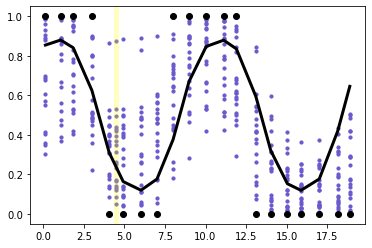

In [167]:
p = idata.posterior.p.stack(samples=['chain', 'draw']).values

plt.axvline(x=x_new, color="yellow", alpha=0.25, lw=5)

ix = np.random.randint(0, p.shape[1], 20)
for i in range(len(ix)):
    plt.scatter(x_both, p[:, i], color="slateblue", s=10);
plt.plot(x, p_true, color="k", lw=3);
plt.plot(x, y, "ok");

Notice the yellow highlight at `x_new=4.46`.  It's not in the range of our original training data, but we've predicted some points there!  We added a dimension to our GP, so now instead of a 20 dimensional normal, it's now 21 dimensional.

Now how do we get a continuous function prediction?  Like anything with computers, you can't really represent "continuous" things -- but you can sample at enough points for things to be continuous enough for your purposes.  Instead of 20 + 1 points, let's do a lot, 20 + 100 points.  That should be enough for this to start "looking" continuous.  We'll use 100 x locations evenly spaced from -2 to 16, so both within the domain of our original `x` and outside of it.

(ANIMATION HERE): have Fadi highlight the lines of code as we talk though them.  Like, "first MCMC proposes a value of eta, and lengthscale (highlight that)...". Talk through the fact that the covariance matrix K is 115 by 115 now (instead of 15 by 15 before).. 

In [168]:
# append the new x's to the end.
x_new = 25 * np.random.rand(100) - 2
x_both = np.concatenate((x, x_new))

with pm.Model() as model:
    # Since we don't know them, we put distributions on the parameters of the kernel, like the lengthscale
    eta = pm.HalfNormal("eta", sigma=1)
    lengthscale = pm.Uniform("lengthscale", lower=1, upper=20)
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=lengthscale)
  
    ## All that math can be written in a couple lines of code
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior("f", X=x_both[:, None])
    
    p = pm.Deterministic("p", at.sigmoid(f))
    # index just the data points into the likelihood
    p = p[:len(x)]
    lik = pm.Bernoulli("lik", p=p, observed=y)

with model:
    idata = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, lengthscale, f_rotated_]
INFO:pymc:NUTS: [eta, lengthscale, f_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 141 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 141 seconds.


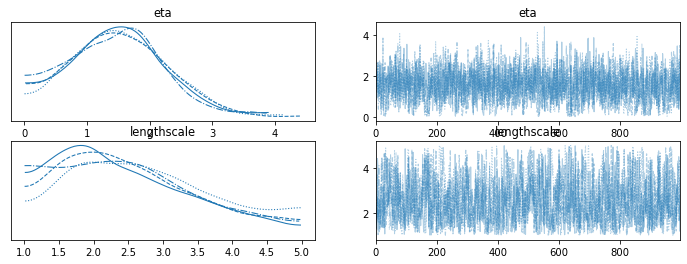

In [171]:
az.plot_trace(idata, var_names=["eta", "lengthscale"]);

Now look at the dots below.  They're basically lines.  

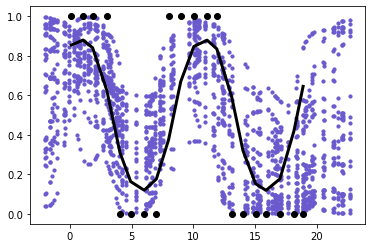

In [169]:
p = idata.posterior.p.stack(samples=['chain', 'draw']).values

ix = np.random.randint(0, p.shape[1], 20)
for i in range(len(ix)):
    plt.scatter(x_new, p[len(x):, i], color="slateblue", s=10);
plt.plot(x, p_true, color="k", lw=3);
plt.plot(x, y, "ok");

Let's make things look a little nicer by plotting a few samples as lines, and then shading the rest of the posterior in now that we've sampled finely enough.

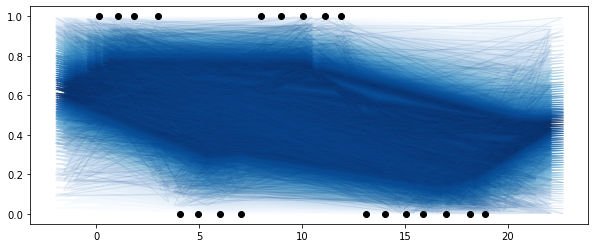

In [170]:
p = idata.posterior.p.stack(samples=['chain', 'draw']).values

ix = np.random.randint(0, p.shape[1], 20)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
pm.gp.util.plot_gp_dist(ax, p[len(x):, :].T, x_new, palette="Blues")

plt.plot(x, y, "ok");

Congratulations on fitting your first GP!  We've managed to fill in and extrapolate our data to arbitrary locations.  This is actually the bare minimum you need to fit a GP to real data. 

# THE END

# ... But wait, is that really it?

In one major sense, yes.  Up until this point we've done 3 things:
1. Made a kernel function
2. Used the kernel as the covariance function of a multivariate normal
3. Fit data, and also used our kernel to extrapolate the GP to new `x` locations

At the simplest level, **that is what a GP is**, no more, and no less.  

$$
f \sim \mathcal{GP}\left(0\,, k(x, x')\right)
$$

However, you may have noticed one, very, very important thing:  When we added the extra 100 points, the runtime slowed **way, way** down, and we had to fit and predict at the same time.  This slow runtime is the Achilles heel of Gaussian processes, which have $\mathcal{O}^3$ computational complexity.  This means that as the size of the data set grows, the runtime scales cubicly!  Just about every other ML algorithm in say, scikit-learn, scales much better than this.

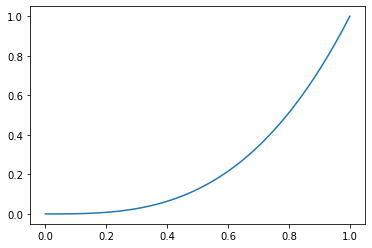

In [115]:
x = np.linspace(0, 1, 100)
y = x**3

plt.plot(x, y);

### Then why does any one actually use them in practice if they are so slow?

Two reasons:

1. GPs are effective modeling tools because they are extremely expressive.  Remember the line and cosine model we first tried to use to fit the Mauna Loa data set?  There are many different types of kernel functions, all of which produce functions with different characteristics.  Also, unlike many scikit-learn models, the results have an interpretation.  Remember the lengthscale parameter?  Although they can represent super complicated functions, GP's aren't really blackbox ML models.

2. There are ways to speed them up.  With (sometimes quite a bit of) math, there are different approximations and also different scenarios where GPs can be sped up, sometimes dramatically.  Using GPs in practice really means knowing when and where to use which approximations.     

So to summarize:
- GP's are extremely expressive modeling tools (interpretable too!)
- GP's are slow

In [55]:
x = np.linspace(0, 10, 200)
cov = pm.gp.cov.ExpQuad(1, ls=2)
K = cov(x[:, None]).eval()
s = pm.draw(pm.MvNormal.dist(mu=np.zeros(200), cov=K), 25)

this

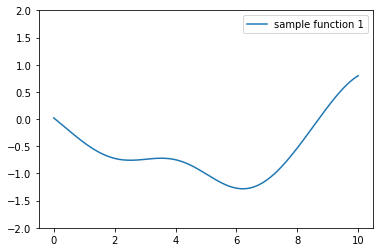

In [56]:
plt.plot(x, s[0, :], color="C0", label="sample function 1");
plt.ylim([-2, 2]);
plt.legend();

and this

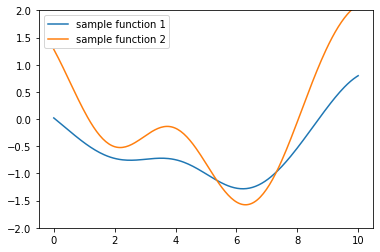

In [57]:
plt.plot(x, s[0, :], color="C0", label="sample function 1");
plt.plot(x, s[1, :], color="C1", label="sample function 2");
plt.ylim([-2, 2]);
plt.legend();

and then this

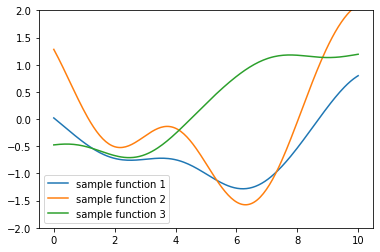

In [58]:
plt.plot(x, s[0, :], color="C0", label="sample function 1");
plt.plot(x, s[1, :], color="C1", label="sample function 2");
plt.plot(x, s[2, :], color="C2", label="sample function 3");
plt.ylim([-2, 2]);
plt.legend();

Here are many many samples

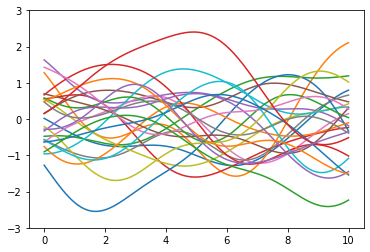

In [59]:
plt.plot(x, s.T);
plt.ylim([-3, 3]);

Unlike a random vector, all of these different paths are functions.  Yes, if we plotted these as dots we'd see that these aren't perfectly smooth lines, BUT, we could plug in more x's wherever we want (functions!) and all the lines would smoothly extend out past 10.

- A normal distribution is an example of a probability distribution over values
- A multivariate normal distribution is an example of a probability distribution over vectors
- **A Gaussian process** is an example of a probability distribution over functions

The key to this whole thing is the covariance function we built before, $k(x, x)'$  Since it's a function of $x$, *and* we can use it as a covariance in a multivariate normal, it allows us to convert the *dimensions* of the multivariate normal, into points on $x$.  

The line between a random vector and a random function may seem a little blurry too.  

- If you observe 5 points along a random function, so only 5 x locations, is that a length 5 random vector? Yes!
- The difference is for random functions there is *a way* to interpolate and extrapolate.  For GPs, that way is the fact that the kernel is a function of $x$.   

## Section Recap

**This section needs a tiny bit more work to explain how we move from discrete to continuous** Likely along the lines of

Instead of just generating a covariance for the data we seen, what if instead we plugged in a value of x and **any other possible value of x**. This is what we did in the Mauna Lao example, were just doing the same here.

Getting real section in here explains it well as does the markdown block right below. Maybe we should move that up into this section?

https://thegradient.pub/gaussian-process-not-quite-for-dummies/

# Sec 70: Gaussian processes

Alright, here it is.  A GP is usually written down as,

$$
f(x) \sim \mathcal{GP}\left(0\,, k(x, x')\right) \,.
$$

Read this as: "The function f(x) is distributed as a Gaussian process with mean zero and covariance function $k(x, x')$.  If we take a fixed set of $x$ values and plug them in, it becomes a multivariate normal random vector.  But before that, since the kernel $k$ is a function over $x$ and $x'$, we have a distribution over functions.  Since there are an infinite number of $x$ values you could plug in (because $x$ can be any number, right?), people say that GPs are an infinite dimensional distribution.  

When we plug in some $x's$, we get a multivariate normal random vector, with elements for each $x$ we plugged in.

$$
\mathbf{f}_x \sim \mathcal{N}\left(0\,, \mathbf{K}_{xx}\right) \,.
$$

We've seen lot's of examples of this already!  Here's some code you've already seen, but now with some annotations.  We are drawing samples from a Gaussian process prior.

## GP Prior

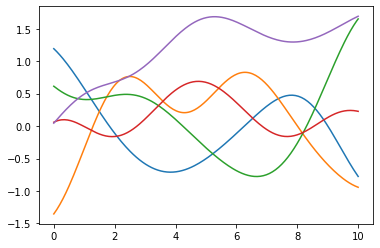

In [62]:
x = np.linspace(0, 10, 200)  # a fixed set of x's, 200 of them. 
cov = pm.gp.cov.ExpQuad(1, ls=2) # a covariance *function*
K_xx = cov(x[:, None]).eval() # evaluate the covariance function over the fixed set of x's, now it's a matrix K_xx
f_x = pm.draw(pm.MvNormal.dist(mu=np.zeros(200), cov=K_xx), 5)  # draw 5 samples of the GP over the fixed set of x's

plt.plot(x, f_x.T);

And now, let's fit our first GP -- **and** let's get some predictions.  Let's use the example from earlier, where we technically we did fit a GP -- but without making predictions at arbitrary $x$.  Let's consider two regions of the domain $x$.  The first is where our data is, this is `x` in the code below.  We'll denote where we want predictions as `xs`.  

## GP Posterior

In [63]:
x = 5 * np.sort(np.random.rand(100))
xs = np.linspace(np.max(x), 10, 100)
x_both = np.concatenate((x, xs))

with pm.Model() as model:
    # Since we don't know them, we put distributions on the parameters of the kernel, like the lengthscale
    eta = pm.HalfNormal("eta", sigma=1)
    lengthscale = pm.Uniform("lengthscale", lower=1, upper=5)
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=lengthscale)
  
    ## All that math can be written in a couple lines of code
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior("f", X=x_both[:, None])
    
    p = pm.Deterministic("p", at.sigmoid(f))
    # index just the data points into the likelihood
    p = p[:len(x)]
    lik = pm.Bernoulli("lik", p=p, observed=y)

with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(target_accept=0.9)

Compiling...
Compilation time =  0:00:02.043777
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:08:29.338653
Transforming variables...
Transformation time =  0:00:09.266784
Computing Log Likelihood...
Log Likelihood time =  0:00:08.924947


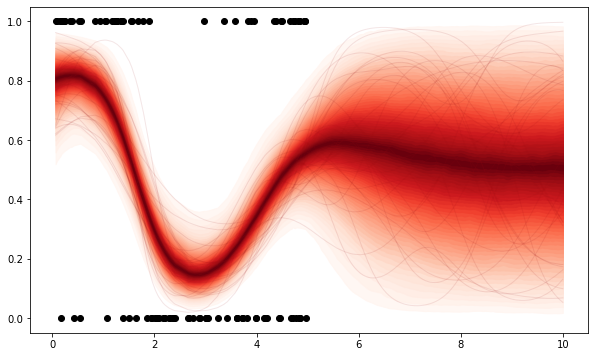

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

p = idata.posterior.p.stack(samples=['chain', 'draw']).values

pm.gp.util.plot_gp_dist(ax, p.T, x=x_both)
plt.plot(x, y, "ok");

It may seem like a minor detail, or an issue about semantics, but the idea of functions over arbitrary x, and a fixed set of x's, is key to what sets GP's apart.  Also notice that we have to fit and predict at the same time.  To do so, we just index our GP points where we have observed data at, the rest are our predictions.

This is what makes GPs such effective modeling tools -- they are extremely expressive.  Remember the line and cosine model we first tried to use to fit the Mauna Loa data set?  GPs are distribution over functions that are defined by the idea of similarity, instead of parameters like slope and y-intercept, or frequency, amplitude and phase.  This is why they are called **non-parametric** models, while models like the line and cosine model are called **parametric** models.  Non-parametric models generally need the whole training data set on hand to make predictions, which is technically true for GPs as well, as we'll see in the next section.  We won't worry too much about the distinction in this course, but you will see these terms around in other places, so this is what they mean.  

## Section Recap (Partially complete pending comment)
* This is where Bayes Formula comes in
  * Our prior functions are ranked by likelihood to determine the ones that are most likely
* This ability to generate random functions and then determine what is most likely is why GPs can "fit anything"
  * This flexibility is also what unfortunately what makes GPs so slow
* There sometimes is a distinction between parametric and non parametric models
  * For practitioners this distinction is not too important

# Sec 80: Conclusion

And that's the basics of GPs! GPs can be boiled down to the sum of two main ingredients, kernels and multivariate Gaussians.  You may have already noticed though that sampling is a bit slow.  This would be foreshadowing for what happens next...  If you take away two things from this course, it should be:

1.  At their core, GPs are simple, and elegent.  You can model many, many kinds of random functions as giant multivariate normal distributions, with a kernel function for the covariance.  The kernel function you use determines the model.  
2.  Scaling GPs to larger data sets is **hard**.  It's not an exaggeration to say that for everything you'll learn about GPs (other than the behaviors of different kernel functions) is about scaling GPs to larger data sets, and making them run faster, and just making them practically usable.
3.  In order for GPs to be usable in all but the simplest cases, you need to fit and predict as a two step process.  We'll show how to do this in a later lesson, when we learn about conditioning and marginalization of multivariate normals.

For instance, in nearly any practical situation, you don't want to fit and predict all in one step, since fitting is so much slower.  The next lesson is about how to condition in GPs to make fitting and predicting a two step process.  Then, the lesson after that one is about the special case where the likelihood is also Gaussian, like in the Mauna Loa example above (but not like the logistic regression example).  There we can exploit something called *conjugacy* to avoid explicitly sampling the GP at the observed data $f$.  If it seems hard to imagine how that's possible, we'll explain later.

The point is, these two concepts are so important for using GPs in practice, that people often include them *when explaining what a GP even is* -- even though as you can see above, we "can" understand, fit, and predict with GPs without them.  

The rest of this course we'll gain a deeper understanding of GPs, challenges to using them in practice.  We'll cover many different type of kernels, beyond those we showed above.  We'll also cover a few very important GP approximations that you'll need when working with real data, at least if it has more than a couple hundred data points.  Most importantly, we'll learn about how to use GPs effectively to create **good** and useful models. 